In [1]:
# %load_ext line_profiler
# %load_ext autoreload         
# %autoreload 2

In [2]:
# Standard library imports
import logging
import time
import json
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector
from qiskit.circuit.library import UnitaryGate
from qiskit.synthesis import TwoQubitWeylDecomposition

# Custom package imports
from pauli_propagation import PauliTerm, PauliPropagator
from pauli_propagation.utils import encode_pauli
from pauli_propagation.gates import QuantumGate
from pauli_propagation.monte_carlo import MonteCarlo
from pauli_propagation import staircasetopology2d_qc
from pauli_propagation.decomposition import su4_kak_reconstruct, su4_kak_decomp

# Configure logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

# Above is first demo

In [3]:
# 到底是XI...I,还是I...IX? 区别是啥？一个是最大纠缠，一个是小纠缠


# 还要写个test suite对比ibm kicked ising和pauli_propagation的state vector方法

# statevector方法传播后的expectation是否有非零虚部

# 需要多种topology的电路，测试pauli_propagation方法的性能

# 复现fig3

# 再次尝试理解一下原文的mse到底在搞啥
# fig2a中的var[f]就是

# Sampling quantum states is currently not supported.

**Var[f] as the cumulative MSE at k=0**

The cumulative MSE is defined in (5) as:
$$
\mathrm{MSE}(k;L)
= \mathbb{E}_U\Bigl[\bigl(f_U(O)-\widetilde f_U^{(k)}(O)\bigr)^2\Bigr]
= \sum_{|\gamma|>k}\mathbb{E}_U\bigl[|\Phi_\gamma(U)|^2\bigr]\;d_\gamma^2,
$$
where $\gamma$ runs over all Pauli paths, $\Phi_\gamma(U)$ are the Fourier coefficients, and $d_\gamma=\mathrm{Tr}[s_\gamma\,\rho]$.

For the special case $k=0$, $\widetilde f_U^{(0)}(O)=0$ (only the identity term is kept) and $\mathbb{E}_U[f_U(O)]=0$, hence
$$
\mathrm{MSE}(0;L)
= \mathbb{E}_U\bigl[f_U(O)^2\bigr]
= \mathrm{Var}[f].
$$
In other words, $\mathrm{Var}[f]$ is exactly the total contribution of all nontrivial Pauli terms (weight $>0$) to the overall MSE.


我还是不理解为什么？还需要再看论文

In [4]:

# Monte Carlo parameters
nx = ny = 5
L_vals = [1,2,3,4]
M = 10000 * 50
max_kk = 6

# Prepare output directory
out_dir = "results/su4"
os.makedirs(out_dir, exist_ok=True)

# # %%
# for L in L_vals:

#     # === 0) Build circuit and initial PauliTerm ===
#     qc_2d = staircasetopology2d_qc(nx, ny, L)
#     n = qc_2d.num_qubits

#     pauli_label = 'Z' + "I" * (n - 1)
#     key = encode_pauli(Pauli(pauli_label))
#     init_term = PauliTerm(1.0, key, n)
#     product_label = "0" * n
#     prop_2d = PauliPropagator(qc_2d)

#     # === 1) Monte Carlo sampling step ===
#     mc = MonteCarlo(qc_2d)
#     _, _, last_weights, _ = mc.monte_carlo_samples(init_term=init_term, M=M)

#     # === 2) Compute weight histogram ===
#     bins = np.arange(0.5, n + 1.5)
#     hist_counts, bin_edges = np.histogram(last_weights, bins=bins, density=False)
#     hist_vals = hist_counts / float(len(last_weights))

#     # === 3) Estimate MSE for all thresholds k ===
#     mse_mc_results_dict = mc.estimate_mse_for_truncation(propagator=prop_2d,
#                                                          product_label=product_label)

#     cum = mse_mc_results_dict['cumulative']
#     layer = mse_mc_results_dict['layer']

#     # === 4) Package results into a dictionary ===
#     result_for_L = {
#         "L": L,
#         "weight_hist": {
#             "hist_vals": hist_vals.tolist(),
#             "bin_edges": bin_edges.tolist(),
#             "hist_counts": hist_counts.tolist()
#         },
#         "cum_mse": {str(k): float(cum.get(k, 0.0)) for k in range(max_kk + 1)},
#         "weight_mse": {str(k): float(layer.get(k, 0.0)) for k in range(max_kk + 1)}
#     }

#     # === 5) Write results to JSON file ===
#     filename = os.path.join(out_dir, f"su4_mc_results_L{L}.json")
#     with open(filename, 'w') as f:
#         json.dump(result_for_L, f, indent=2)

#     print(f"Completed MC sampling for L={L}, results saved to: {filename}")


In [5]:
L_vals = [1,2,3,4]
mc_results_dict = {"weight_mse":  { str(k): [] for k in range(max_kk + 1) },
                   "cum_mse":     { str(k): [] for k in range(max_kk + 1) },
                   "weight_hist": {}}

# 3) 对每个 L，打开对应的 JSON 文件，把数据载入并追加到 mc_results_dict

for L in L_vals:
    filename = os.path.join(out_dir, f"su4_mc_results_L{L}.json")
    with open(filename, "r") as f:
        data_L = json.load(f)

    # a) 把单层 ΔMSE (weight_mse) 和 累计 MSE (cum_mse) 追加到各自列表里
    #    注意：JSON 里键是字符串 "0","1",…，我们这里保持一致
    for k in range(max_kk + 1):
        mc_results_dict["weight_mse"][str(k)].append(data_L["weight_mse"][str(k)])
        mc_results_dict["cum_mse"][str(k)].append(data_L["cum_mse"][str(k)])

    # b) 把直方图 “weight_hist” 也存进去：直接用 L 的字符串作为键，
    #    值仍然是一个包含 hist_vals/list 和 bin_edges/list 的 dict
    mc_results_dict["weight_hist"][str(L)] = data_L["weight_hist"]


In [6]:
# estimate_mse_for_truncation(...)[‘cumulative’] → Fig 2(a)（累积 MSE 曲线）

# estimate_mse_for_truncation(...)[‘layer’] → Fig 2(c) inset（分层 MSE 柱状图）

[0.00321, 0.0010666666666666667, 0.00029, 4.6666666666666665e-05]
[0.00074, 0.00019333333333333333, 4e-05, 2.3333333333333332e-05]
[0.00013866666666666666, 1.2666666666666667e-05, 6.666666666666667e-06, 1.3333333333333334e-06]
[5.7142857142857145e-06, 1.7142857142857143e-06, 1e-06, 2.857142857142857e-07]


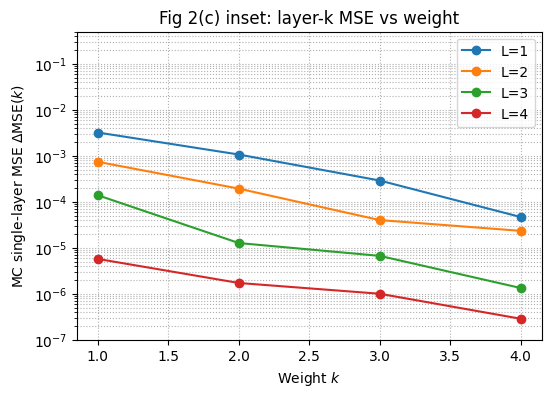

In [25]:
# —— 单层 ΔMSE vs weight (Fig 2c) —— 
plt.figure(figsize=(6,4))
for L in L_vals:
    kk_vals = list(range(1,5))
    ys = [mc_results_dict['weight_mse'][f"{kk}"][L_vals.index(L)] for kk in kk_vals]
    print(ys)
    plt.plot(kk_vals, ys, marker='o', label=f'L={L}')
plt.yscale('log')
plt.ylim(1e-7,5e-1)  # 设置 y 轴最小值为 10e-8
plt.xlabel('Weight $k$')
plt.ylabel('MC single-layer MSE $\\Delta\\mathrm{MSE}(k)$')
plt.title('Fig 2(c) inset: layer-k MSE vs weight')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.show()


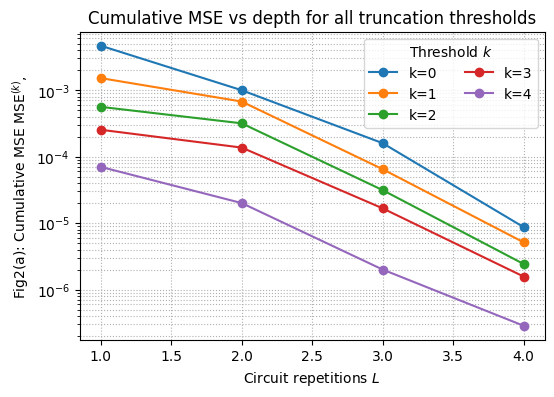

In [26]:
# —— cumulative MSE vs circuit repetitions for all kk from 0 to max_kk —— 
plt.figure(figsize=(6, 4))
for kk in range(0,5):
    ys = mc_results_dict['cum_mse'][f"{kk}"]   # list of length len(L_vals)
    plt.plot(L_vals, ys, marker='o', label=f'k={kk}')
plt.yscale('log')
plt.xlabel('Circuit repetitions $L$')
plt.ylabel('Fig2(a): Cumulative MSE $\\mathrm{MSE}^{(k)}$, ')
plt.title('Cumulative MSE vs depth for all truncation thresholds')
plt.legend(title='Threshold $k$', ncol=2)
plt.grid(True, which='both', ls=':')
plt.show()

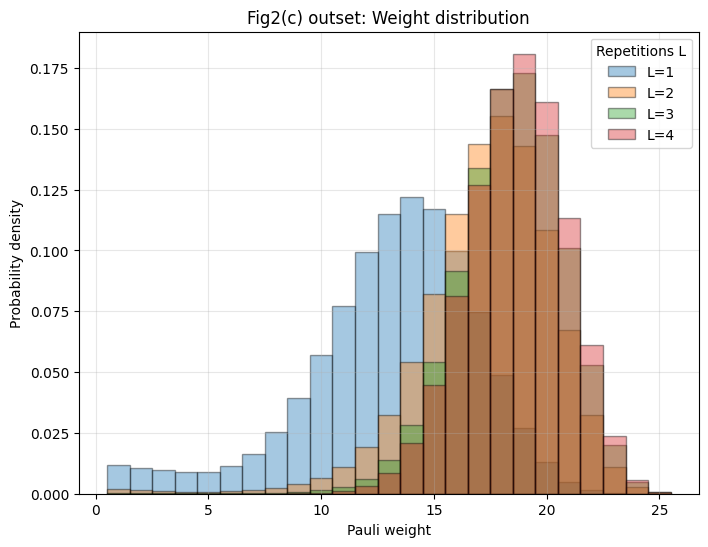

In [27]:
plt.figure(figsize=(8,6))

for L in L_vals:
    entry     = mc_results_dict['weight_hist'][str(L)]  # 注意用 str(L) 或者你已转换成 int 的 key
    hist_vals = entry['hist_vals']    # 已经是 float 列表
    bin_edges = entry['bin_edges']    # 已经是 float 列表，长度 = len(hist_vals)+1

    # 推荐用 zip 来计算每对相邻边界的差值
    widths = [b2 - b1 for b1, b2 in zip(bin_edges[:-1], bin_edges[1:])]

    # 画条形图
    plt.bar(bin_edges[:-1], hist_vals, width=widths,
            align='edge', edgecolor='black', alpha=0.4, label=f"L={L}")

plt.xlabel("Pauli weight")
plt.ylabel("Probability density")
plt.title(f"Fig2(c) outset: Weight distribution")
plt.legend(title="Repetitions L")
plt.grid(alpha=0.3)
plt.show()


In [28]:
k_vals = [1,2,3,4]
L_vals = [1,2,3,4]
nx = ny = 5
prop_results_dict = {'prop_time':    {k: [] for k in k_vals},
                     'exp_time':     {k: [] for k in k_vals},
                     'expectation':  {k: [] for k in k_vals},}


su4_prop_output_path = "results/su4/su4_prop_results_dict.json"

# for L in L_vals:
#     # 0) 构造电路与初始 PauliTerm
#     qc_2d = staircasetopology2d_qc(nx, ny, L)
#     n = qc_2d.num_qubits
#     pauli_label = "X" + "I" * (n - 1)
#     key = encode_pauli(Pauli(pauli_label))
#     init_term = PauliTerm(1.0, key, n)
#     product_label = "0" * n
#     prop_2d = PauliPropagator(qc_2d)

#     # 4) 对每个 k 填入其它结果
#     for k in k_vals:

#         # 精确 propagate + expectation 并计时
#         t0 = time.time()
#         layers_trunc = prop_2d.propagate(init_term, max_weight=k, use_parallel=False)
#         t_prop = time.time() - t0

#         t1 = time.time()
#         est_exp = prop_2d.expectation_pauli_sum(layers_trunc[-1], "0" * n)
#         t_exp = time.time() - t1

#         prop_results_dict['prop_time'][k].append(t_prop)
#         prop_results_dict['exp_time'][k].append(t_exp)

#         # 保存精确 expectation 值
#         prop_results_dict['expectation'][k].append(est_exp)



# with open(su4_prop_output_path, "w") as f:
#     json.dump(prop_results_dict, f, indent=2)

# print(f"Results saved to {su4_prop_output_path}")


In [29]:
with open(su4_prop_output_path, "r") as f:
    raw = json.load(f)

# 2) Convert the second‐level keys back to ints
prop_results_dict = {}
for metric, subdict in raw.items():
    # metric is one of 'prop_time', 'exp_time', 'expectation'
    prop_results_dict[metric] = {int(k): v for k, v in subdict.items()}

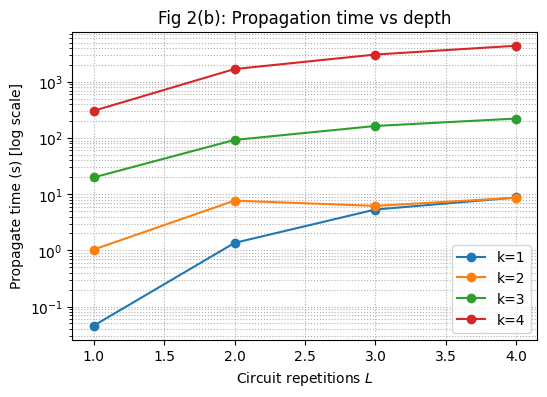

In [30]:
# 2) 精确截断 propagate 时间 vs 深度 (Fig 2(b))，y 轴改为 log10
plt.figure(figsize=(6, 4))
for k in k_vals:
    ts = prop_results_dict['prop_time'][k]
    plt.plot(L_vals, ts, marker='o', label=f'k={k}')
plt.yscale('log')  # 切换到对数刻度（10 为底）
plt.xlabel('Circuit repetitions $L$')
plt.ylabel('Propagate time (s) [log scale]')
plt.title('Fig 2(b): Propagation time vs depth')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.show()


# above is reproducing paper figs

In [13]:
# 新开一个monte_carlo.py， 把monte carlo的代码写成一个Class
# Class里面需要有抽样代码， 计算mse代码， 计算bias代码

# 做for loop
# 5*5电路有mse和bias
# 

In [14]:
# 需要用Monte carlo来估计expectation， 不同weight对expectation的contribution
# 需要画出样本的mse，以及不同的weight对mse的contribution
# time-circuit/trunc weight
# var

In [15]:
# 5,5, 1 layer, weight 3,  single core 16.8s
# 5,5, 2 layer, weight 3, single core: 

# 6,6, 1 layer, weight 3, einsum, 74s, multi core: 42s/44s
# 6,6, 2 layer, weight 3, single core: 300s, multi core: 202s
# 6,6, 1 layer, weight 3, 6cores, 46s

# 7,7, 1 layer, weight 3, mutli core(8core,2000): 141s
# 7,7, 1 layer, weight 3, mutli core(4core,2000): 170s
# 7,7, 1 layer, weight 3, mutli core(4core,4000): 170
# 7,7, 1 layer, weight 3, mutli core(4core,1000): 178
# 7,7, 1 layer, weight 3, mutli core(8core,4000): 145s
# 8,8, 1 layer, weight 3, einsum，16，12min40s, multi core: 7min
# 
# 0.12079133418758356

In [16]:
# 8,8, 1 layer, weight 3, 44min39s

In [17]:
# 25 qubit, 1 layer, weight 3, 1min1s
# 36 qubit, 1 layer, weight 3, takes 3min46s, 

In [18]:
# # ─── Evolve the statevector through the 2D staircase circuit ─────────────────
# psi0 = Statevector.from_label("+" * n)
# psi_final = psi0.evolve(qc_2d)

# # ─── Compute and print the expectation value ───────────────────────────────────
# exp_val = psi_final.expectation_value(obs).real
# print(f"⟨X on qubit 0⟩ from statevector simulation: {exp_val:.6f}")

In [19]:

# 实现并行化Monte Carlo


In [20]:
# %lprun -f PauliPropagator.propagate \
# prop_2d.propagate(PauliTerm(1.0, Pauli(pauli_label)), max_weight=3)

In [21]:



# prop_2d   = PauliPropagator(qc_2d)
# print('1')

# %lprun -f PauliPropagator.propagate \
# layers_2d = prop_2d.propagate(PauliTerm(1.0, Pauli(pauli_label)), max_weight = 3)   
# print('2')
# expect_2d = prop_2d.expectation_pauli_sum(pauli_sum= layers_2d[-1],
#                                     product_label= plus_label)   # |+⟩^{⊗n}                  
# print('3')
# print(expect_2d)

In [22]:
# after passing all test, play with truncation
# implement more gates (should be fully compatble with qiskit)
# compare simulation with tensor network, quimb
# play with circuit people considered(various optimisaiton)

In [23]:
# 写test suite
# 和state vector方法对比性能
# implement更多门
# QuantumGate.get(instr.operation.name)

# 知道电路在很多observable下的expectation不就行了嘛？为什么还要费劲巴拉地做simulation?

# 还是不太理解_cx_rule和_t_rule的具体实现，给我例子说明具体实现

# 没见过这种语法：bucket: defaultdict[str, complex] = defaultdict(complex)


# _cx_rule 以及 PauliPropagation” 的设计思路有帮助。它们一起完成“在泡利基中对可观测量做非 Clifford 演化并在重量上进行截断”的功能。


#     @classmethod
#     def register(cls, name: str):
#         """Decorator: register a new rule under *name* and
#         attach it as <NAME>gate attribute for convenience."""
#         def wrapper(func: Callable):
#             cls._registry[name] = func
#             setattr(cls, f"{name.upper()}gate", staticmethod(func))
#             return staticmethod(func)
#         return wrapper
